In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')
rcParams['figure.figsize'] = (12, 9)

In [46]:
train = pd.read_csv('input/store-sales-time-series-forecasting/train.csv')
event = pd.read_csv('input/store-sales-time-series-forecasting/holidays_events.csv')
stores=pd.read_csv('input/store-sales-time-series-forecasting/stores.csv')
weekday=pd.read_csv('weekday.csv')
test=pd.read_csv('input/store-sales-time-series-forecasting/test.csv')
submission=pd.read_csv('input/store-sales-time-series-forecasting/sample_submission.csv')

In [32]:
train=pd.concat([train,test],axis=0)
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0
28509,3029397,2017-08-31,9,PRODUCE,NaN,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


In [33]:
data=train.merge(event,how='left',on='date')
Holiday = pd.get_dummies(data.type, prefix='type')
transferred= pd.get_dummies(data.transferred, prefix='transferred')
data=data.drop(columns=['type','description','transferred','locale','locale_name'])
data=pd.concat([data,Holiday,transferred],axis=1)

data=data.merge(weekday,how='left',on='date')
weekday_one_shot=pd.get_dummies(data.weekday, prefix='weekday')
data=data.drop(columns=['weekday'])
data=pd.concat([data,weekday_one_shot],axis=1)

family=pd.get_dummies(data.family, prefix='weekday')
data=data.drop(columns=['family'])
data=pd.concat([data,family],axis=1)

In [34]:
import datetime
data['date']=pd.to_datetime(data['date']).map(datetime.datetime.toordinal)
data

,id,date,store_nbr,sales,onpromotion,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,...,weekday_MAGAZINES,weekday_MEATS,weekday_PERSONAL CARE,weekday_PET SUPPLIES,weekday_PLAYERS AND ELECTRONICS,weekday_POULTRY,weekday_PREPARED FOODS,weekday_PRODUCE,weekday_SCHOOL AND OFFICE SUPPLIES,weekday_SEAFOOD
0,0,734869,1,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,734869,1,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,734869,1,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,734869,1,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,734869,1,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,3029395,736572,9,NaN,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3082856,3029396,736572,9,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3082857,3029397,736572,9,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3082858,3029398,736572,9,NaN,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [36]:
data.describe()

,id,date,store_nbr,sales,onpromotion,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,...,weekday_MAGAZINES,weekday_MEATS,weekday_PERSONAL CARE,weekday_PET SUPPLIES,weekday_PLAYERS AND ELECTRONICS,weekday_POULTRY,weekday_PREPARED FOODS,weekday_PRODUCE,weekday_SCHOOL AND OFFICE SUPPLIES,weekday_SEAFOOD
count,3.082860e+06,3.082860e+06,3.082860e+06,3.054348e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,...,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06
mean,1.518250e+06,7.357224e+05,2.750000e+01,3.590209e+02,2.657692e+00,2.196532e-02,1.734104e-03,3.236994e-02,9.942197e-02,5.202312e-03,...,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02
std,8.742912e+05,4.919507e+02,1.558579e+01,1.107286e+03,1.236626e+01,1.465703e-01,4.160646e-02,1.769806e-01,2.992278e-01,7.193921e-02,...,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01
min,0.000000e+00,7.348690e+05,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.618048e+05,7.352970e+05,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.521828e+06,7.357245e+05,2.750000e+01,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.272940e+06,7.361470e+05,4.100000e+01,1.960110e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.029399e+06,7.365720e+05,5.400000e+01,1.247170e+05,7.410000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [37]:
data.drop(data[(data['type_Event'] ==1) ].index, inplace=True)

In [40]:
test=data.drop(data[(data['id'] <3000888) ].index)

data=data.drop(data[(data['id'] >=3000888) ].index)

              id    date  store_nbr  sales  onpromotion  type_Additional  \
3054348  3000888  736557          1    NaN            0                0   
3054349  3000889  736557          1    NaN            0                0   
3054350  3000890  736557          1    NaN            2                0   
3054351  3000891  736557          1    NaN           20                0   
3054352  3000892  736557          1    NaN            0                0   
...          ...     ...        ...    ...          ...              ...   
3082855  3029395  736572          9    NaN            1                0   
3082856  3029396  736572          9    NaN            0                0   
3082857  3029397  736572          9    NaN            1                0   
3082858  3029398  736572          9    NaN            9                0   
3082859  3029399  736572          9    NaN            0                0   

         type_Bridge  type_Event  type_Holiday  type_Transfer  ...  \
3054348          

<AxesSubplot:>

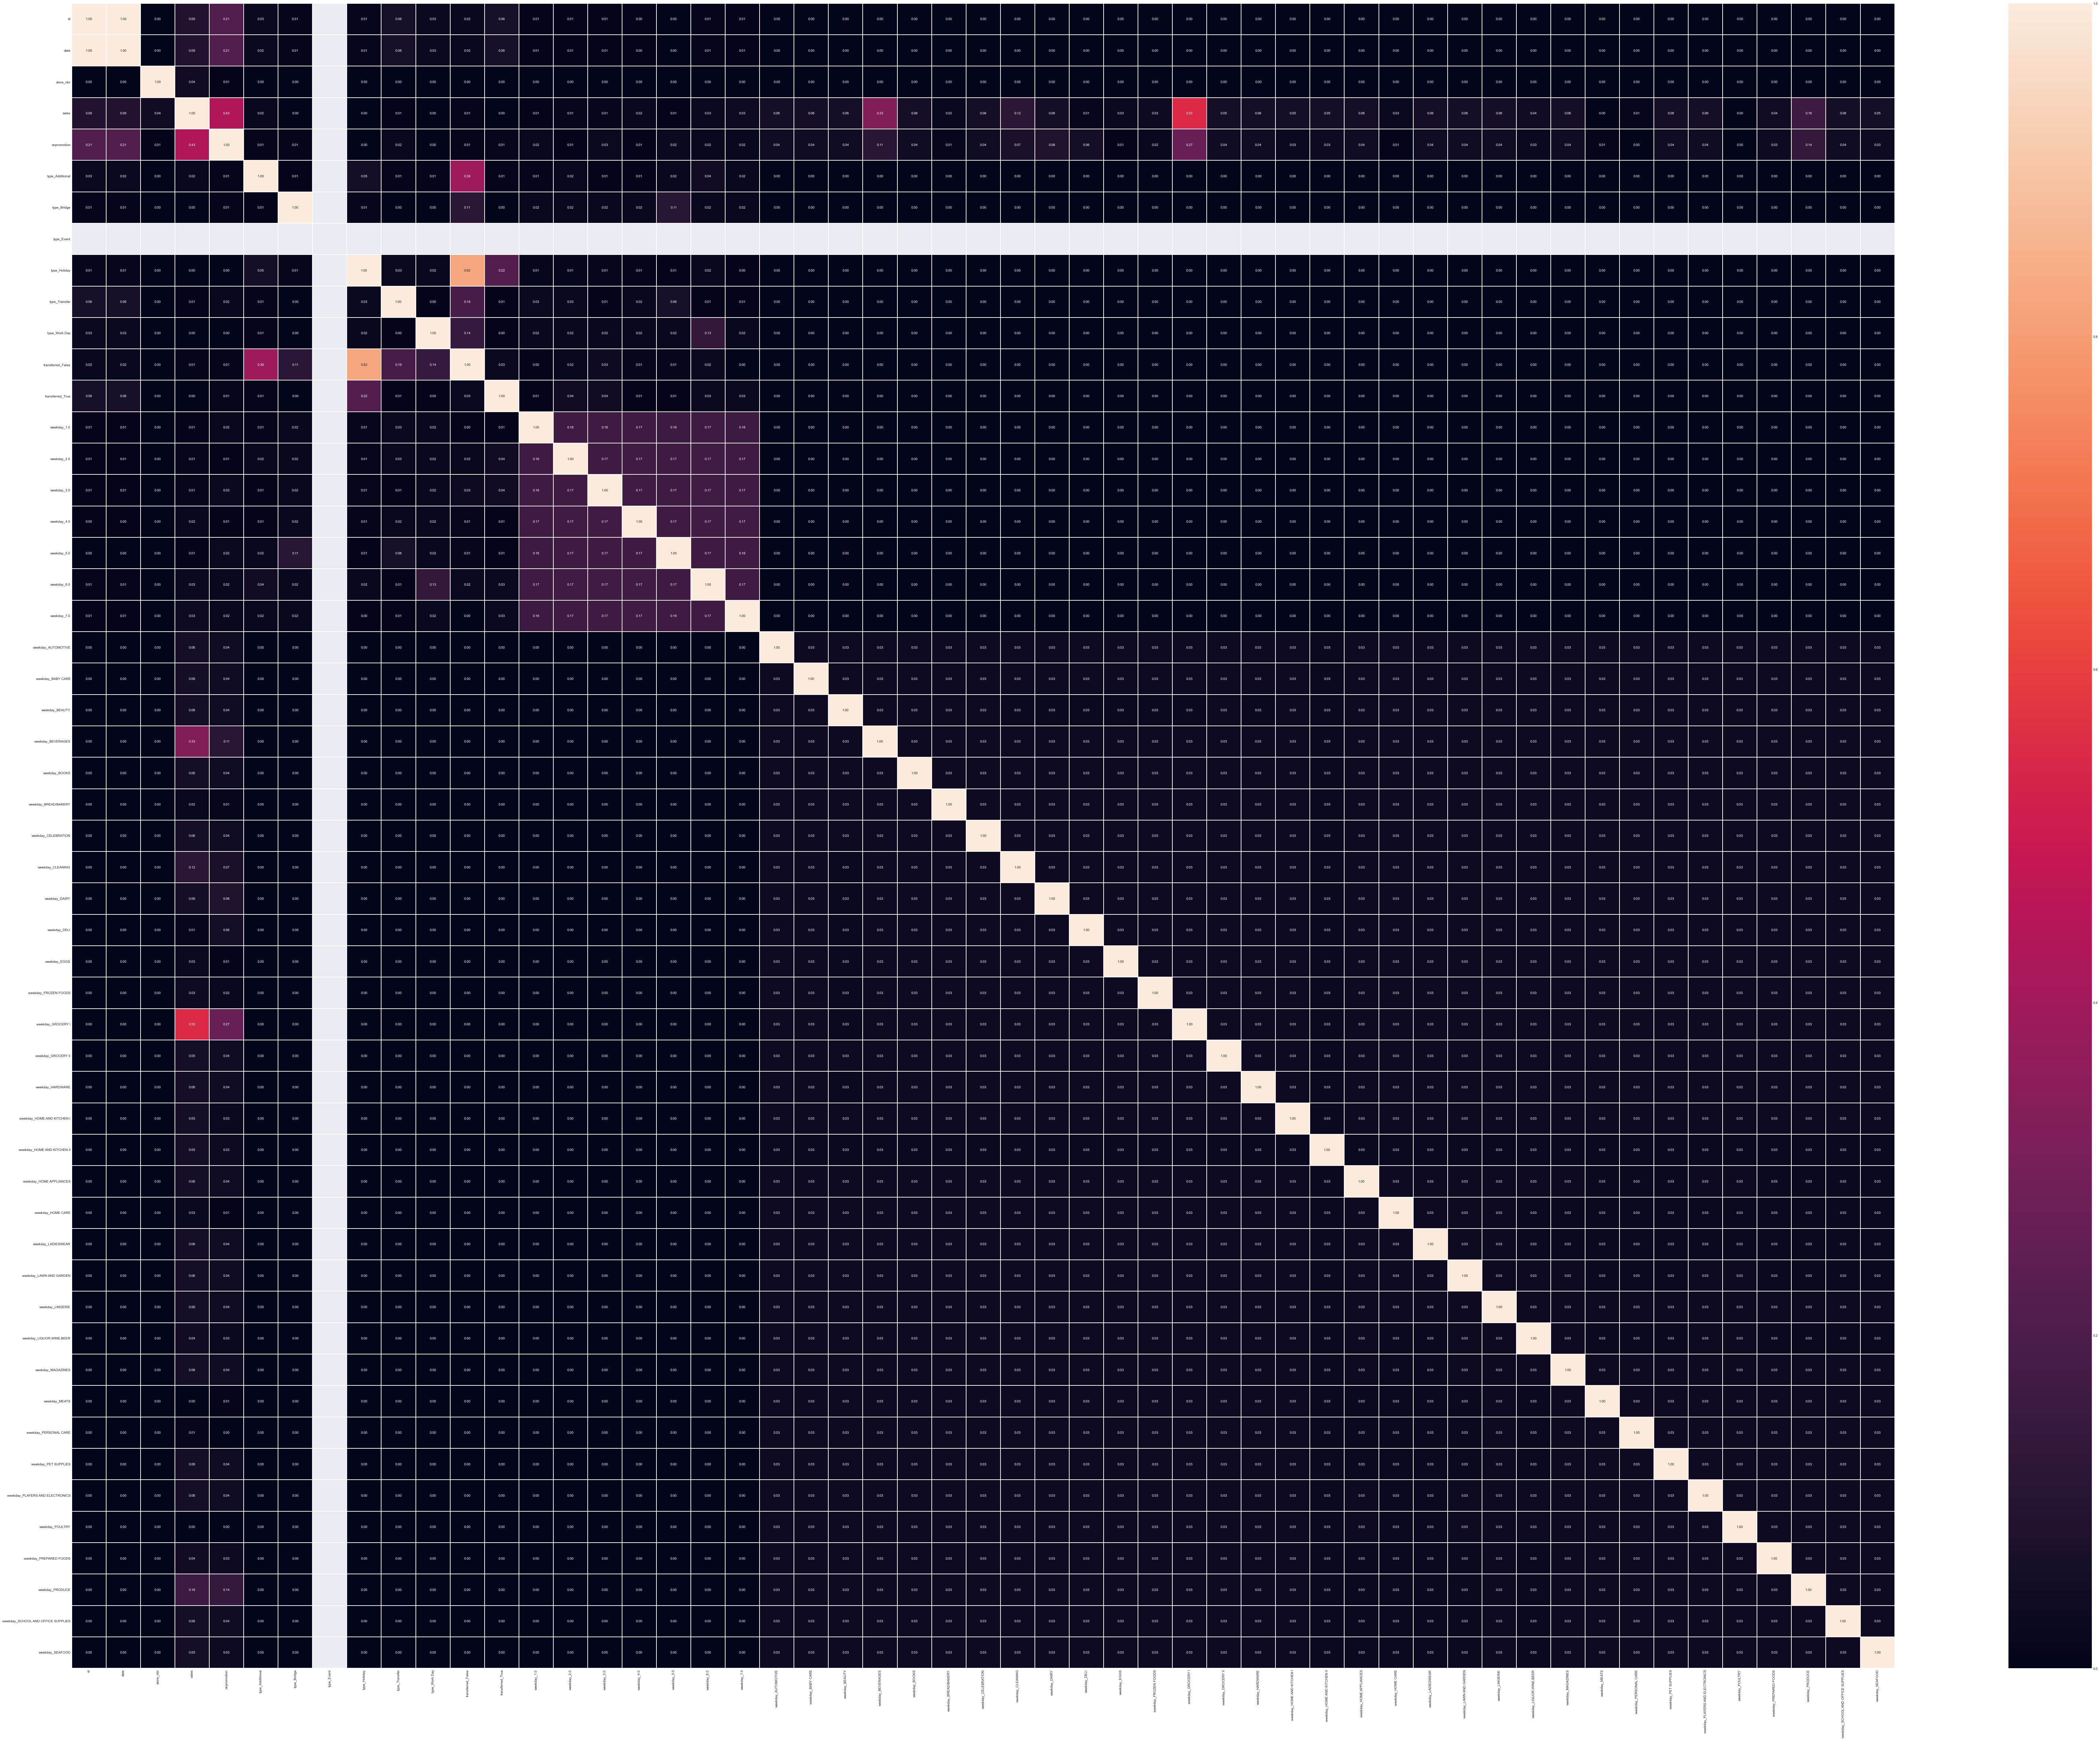

In [41]:
rcParams['figure.figsize'] = (120,90)
sns.heatmap(data.corr().abs(), vmin=0, annot = True, fmt='.2f', vmax=1, linewidths=.3)

In [42]:


X = data.drop(['sales','id'],axis = 1)
y = data['sales']

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as rmsle
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
DTR = DecisionTreeRegressor(random_state = 42)
DTR.fit(X_train,y_train)
predict_RFR = DTR.predict(X_test)

In [43]:
print(f"RMSLE: {(rmsle(y_test, predict_RFR))*100:0.2f}%")

RMSLE: 31.14%


In [44]:
test=test.drop(['sales','id'],axis = 1)


In [45]:
predict_RFR_sub = DTR.predict(test)

In [47]:
submission['sales'] = predict_RFR_sub
submission.to_csv('./submission.csv', index = False)
submission.head(10)

,id,sales
0,3000888,2.000
1,3000889,0.000
2,3000890,10.000
3,3000891,1659.000
4,3000892,0.000
5,3000893,243.220
6,3000894,3.000
7,3000895,651.000
8,3000896,884.000
9,3000897,135.268
